# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "html5lib")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.585, 即時現金賣出: 30.255


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [3]:
for tr in rate_table:
    buy = tr.find(name='td', attrs={'data-table':'本行現金買入'}).text.strip()
    sell = tr.find(name='td', attrs={'data-table':'本行現金賣出'}).text.strip()
    
    print(tr.find('div', class_='visible-phone').text.strip())
    print(f'即時現金買入: {buy}, 即時現金賣出: {sell}')
    print('-----------------------------------------------')

美金 (USD)
即時現金買入: 29.585, 即時現金賣出: 30.255
-----------------------------------------------
港幣 (HKD)
即時現金買入: 3.709, 即時現金賣出: 3.913
-----------------------------------------------
英鎊 (GBP)
即時現金買入: 35.28, 即時現金賣出: 37.4
-----------------------------------------------
澳幣 (AUD)
即時現金買入: 19.15, 即時現金賣出: 19.93
-----------------------------------------------
加拿大幣 (CAD)
即時現金買入: 20.87, 即時現金賣出: 21.78
-----------------------------------------------
新加坡幣 (SGD)
即時現金買入: 20.48, 即時現金賣出: 21.39
-----------------------------------------------
瑞士法郎 (CHF)
即時現金買入: 30.04, 即時現金賣出: 31.24
-----------------------------------------------
日圓 (JPY)
即時現金買入: 0.2698, 即時現金賣出: 0.2826
-----------------------------------------------
南非幣 (ZAR)
即時現金買入: -, 即時現金賣出: -
-----------------------------------------------
瑞典幣 (SEK)
即時現金買入: 2.71, 即時現金賣出: 3.23
-----------------------------------------------
紐元 (NZD)
即時現金買入: 17.8, 即時現金賣出: 18.65
-----------------------------------------------
泰幣 (THB)
即時現金買入: 0.8134, 即時現金賣出: 1.0034
--------------

## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

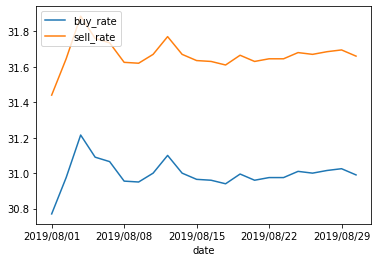

In [4]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

In [24]:
url = 'https://rate.bot.com.tw/xrt/history/'
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "html5lib")

currency_tables = html.find_all('div', 'control-group')
currency_list = list()

for table in currency_tables:
    label = table.find('label', attrs = {'title' : "查詢幣別"})
    if label:
        options = table.find('div', 'controls').find_all('option')
        for option in options:
            currency_list.append(option['value'].strip())     

print(currency_list)

['USD', 'HKD', 'GBP', 'AUD', 'CAD', 'SGD', 'CHF', 'JPY', 'ZAR', 'SEK', 'NZD', 'THB', 'PHP', 'IDR', 'EUR', 'KRW', 'VND', 'MYR', 'CNY']


美金 (USD)


<Figure size 720x576 with 0 Axes>

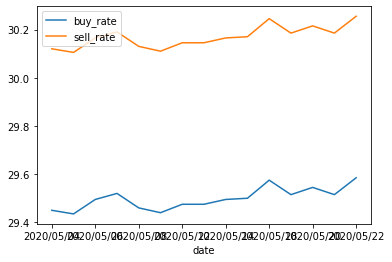

港幣 (HKD)


<Figure size 720x576 with 0 Axes>

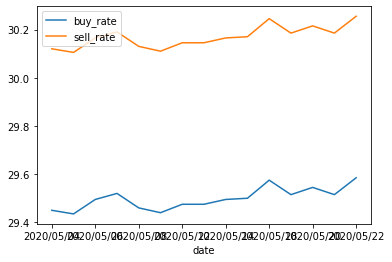

英鎊 (GBP)


<Figure size 720x576 with 0 Axes>

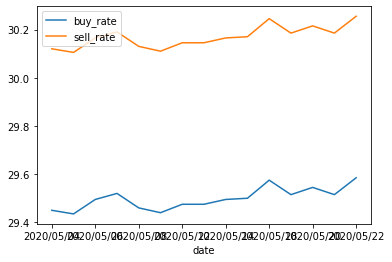

澳幣 (AUD)


<Figure size 720x576 with 0 Axes>

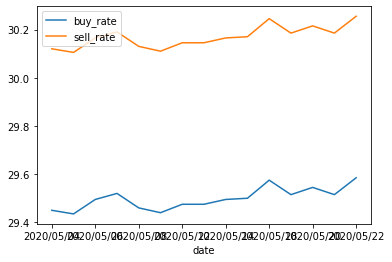

加拿大幣 (CAD)


<Figure size 720x576 with 0 Axes>

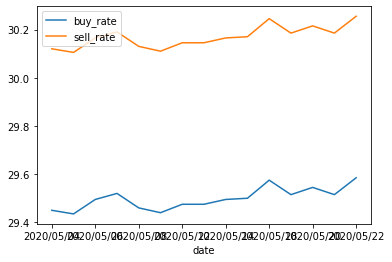

新加坡幣 (SGD)


<Figure size 720x576 with 0 Axes>

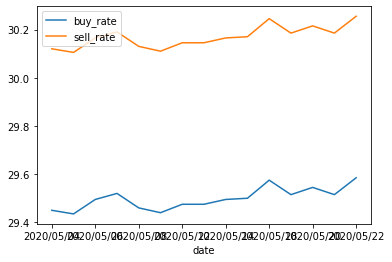

瑞士法郎 (CHF)


<Figure size 720x576 with 0 Axes>

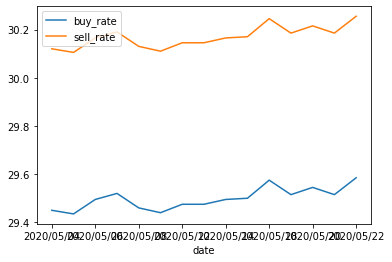

日圓 (JPY)


<Figure size 720x576 with 0 Axes>

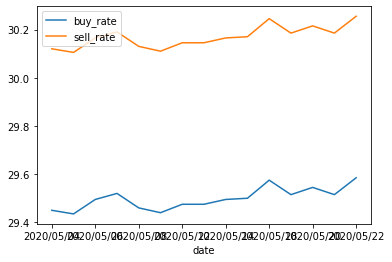

南非幣 (ZAR)


<Figure size 720x576 with 0 Axes>

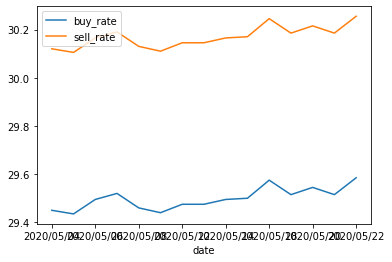

瑞典幣 (SEK)


<Figure size 720x576 with 0 Axes>

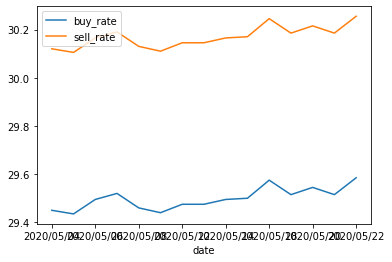

紐元 (NZD)


<Figure size 720x576 with 0 Axes>

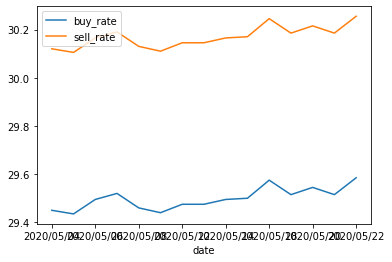

泰幣 (THB)


<Figure size 720x576 with 0 Axes>

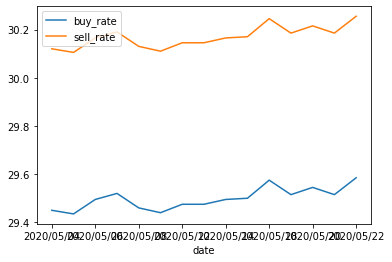

菲國比索 (PHP)


<Figure size 720x576 with 0 Axes>

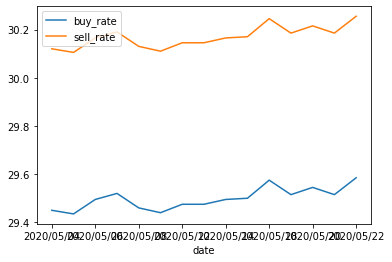

印尼幣 (IDR)


<Figure size 720x576 with 0 Axes>

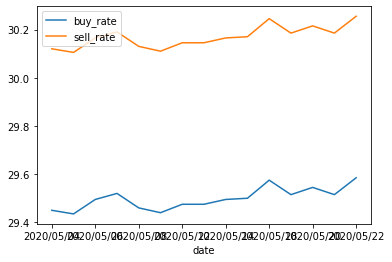

歐元 (EUR)


<Figure size 720x576 with 0 Axes>

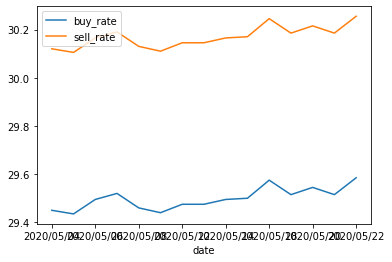

韓元 (KRW)


<Figure size 720x576 with 0 Axes>

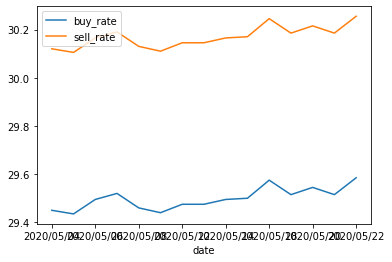

越南盾 (VND)


<Figure size 720x576 with 0 Axes>

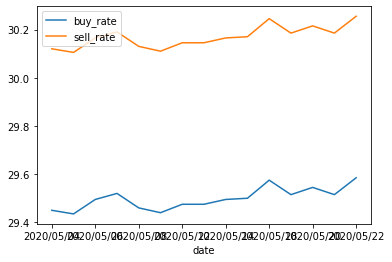

馬來幣 (MYR)


<Figure size 720x576 with 0 Axes>

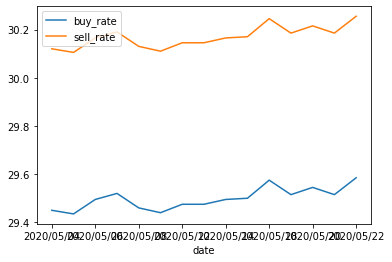

人民幣 (CNY)


<Figure size 720x576 with 0 Axes>

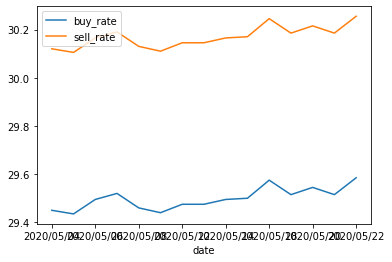

In [5]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "html5lib")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
for rate in rate_table:

    currency = rate.find(name='div', attrs={'class':'visible-phone print_hide'})
    print(currency.text.strip())  # 貨幣種類

    # 針對美金，找到其「歷史匯率」的首頁 
    history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
    history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

    #
    # 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
    #
    # 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
    quote_history_url = history_rate_link.replace("history", "quote/2020-05")
    resp = requests.get(quote_history_url)
    resp.encoding = 'utf-8'
    history = BeautifulSoup(resp.text, "html5lib")
    history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

    #
    # 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
    #
    date_history = list()
    history_buy = list()
    history_sell = list()

    for history_rate in history_table:
        # 擷取日期資料
        date_string = history_rate.a.get_text()
        date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
        date_history.append(date)  # 日期歷史資料

        history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
        history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

    # 將匯率資料建成dataframe形式
    HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                        'buy_rate':history_buy,
                                        'sell_rate':history_sell})

    HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
    HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

    # 畫出歷史匯率軌跡圖
    plt.figure(figsize=(10, 8))
    HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
    plt.legend(loc="upper left")
    plt.show()